# Import libraries and modules

In [35]:
from Environments import *
from DQN import *

# Define the settings of the environment

In [36]:
class Settings:
    """Define settings of the environment such as course shape, course characteristics
       possible actions, position, neural-network parameters and training parameters

    Example usage:
        > settings = Settings()
    """
    def __init__(self):
        # Define road segments, this whole sequence is an ellipsis course
        # Starts with straight horizontal line, draw elliptical section
        # then another straight line and then close with another ellipsis
        self.road_segments = [
            {
                'x': lambda t: t,
                'y': lambda t: 0.000001*t,
                't_start': 0,
                't_end': 10
            },
            {
                'x': lambda t: 10 + 5 * sp.sin(np.pi * (t - 10)),
                'y': lambda t: 5-5 * sp.cos(np.pi * (t - 10)),
                't_start': 10,
                't_end': 11
            },
            {
                'x': lambda t: 21-t,
                'y': lambda t: 8 +2*sp.cos(np.pi * (t - 11)/10),
                't_start': 11,
                't_end': 21
            },
            {
                'x': lambda t: 3 * sp.sin(np.pi * (t - 20)),
                'y': lambda t: 3 - 3 * sp.cos(np.pi * (t - 20)),
                't_start': 21,
                't_end': 22
            }
        ]
        # Define road parameters such as width and length
        self.road_width    = 1
        self.road_length   = 15
        # Closed is a boolean that indicates whether the circuit is closed
        # (I presume)
        self.closed        = False
        # Road resolutions refers to how coarse the grid that constitutes the
        # course is (affects number of states)
        self.road_resolution = 100


        # car settings

        # car initial position
        self.init_car_x = 4
        self.init_car_y = 0
        self.init_car_theta = 0

        self.init_car_speed = .25

        #sensors
        self.n_sensors = 7
        self.resolution = .3
        self.max_sensor_range = 3

        #actions
        self.action_dim = 7  # Actions for steering
        self.actions = 0.5*np.linspace(-1,1,self.action_dim)

        ## NN
        self.state_dim = self.n_sensors  * self.max_sensor_range / self.resolution   # State dimension is the number of sensor
        self.Hidden_layers = [32, 16]
        # Define the gamma and alpha
        self.gamma  = .95
        self.alpha  = .95

        # training
        self.epsilon = 0.05
        self.lr      = 0.001
        self.num_episodes = 100

# Create the settings and environment objects

In [37]:
settings = Settings()
roadenv = RoadEnv(settings)
carenv = CarEnv(settings, roadenv)

TypeError: CarEnv.__init__() takes 2 positional arguments but 3 were given

In [38]:
def get_valid_input(a, b):
    """
    Get a valid integer input from the user between a and b
    args:
        param a: lower bound
        param b: upper bound
    return:
        integer between a and b or 'q' to quit
    """
    while True:
        user_input = input(f"Enter an integer between {a} and {b}, or 'q' to quit: ").strip().lower()

        if user_input == 'q':
            return 'q'

        try:
            number = int(user_input)
            if a <= number <= b:
                return number
            else:
                print(f"Please enter a number between {a} and {b}.")
        except ValueError:
            print("Invalid input. Please enter a valid integer or 'q'.")

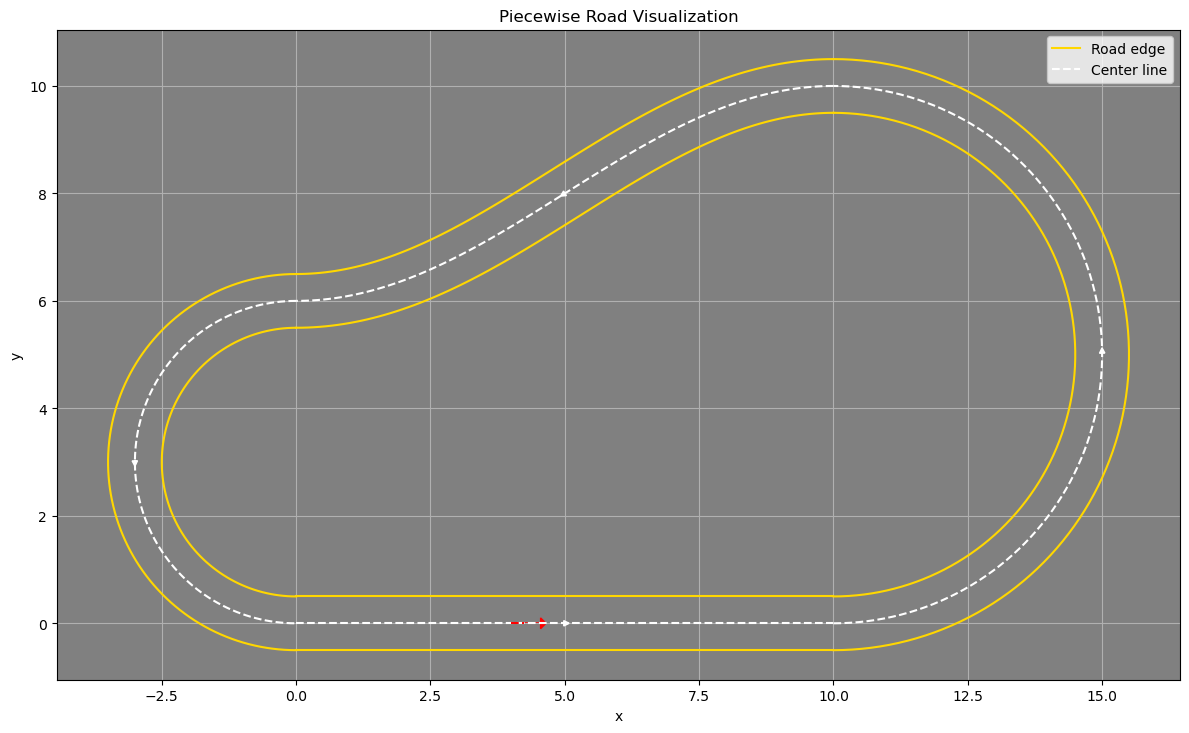

NameError: name 'roadenv' is not defined

In [39]:
for i in range(50):
    Visualize(roadenv, carenv, settings)
    print('')
    action_number =  get_valid_input(1,settings.action_dim)

    action = settings.actions[action_number]
    if action == 'q':
        break
    state, reward = carenv.step(action)
    if carenv.terminal:
        print(f"Episode {i+1} finished")
        break
    else:
        print(f"Episode {i+1} ")
        print(f'self.x: {carenv.x:.2f}  self.y: {carenv.y:.2f}')
        prinf(f'direction: {carenv.theta:.2f}   reward: {reward:.2f}    action: {action:.2f}    action_number: {action_number}')
        print(f'self.terminal: {carenv.terminal:.2f}')
        print(f'state: {state}')